# CNN training example

This notebook illustrates how to use EDIT pipeline to train a simple CNN model on the ERA5 lowres dataset.

Make sure to set the `ERA5LOWRES` environment variable to make the ERA5 low-resolution archive foundable on your system.
Modify the following cell as follows:

- for NCI

```
%env ERA5LOWRES=/g/data/wb00/NCI-Weatherbench/5.625deg
```

- for NIWA

```
%env ERA5LOWRES=/nesi/nobackup/niwa00004/riom/weatherbench/5.625deg
```

- for MO

```
%env ERA5LOWRES=/data/users/infolab/weatherbench/5.625deg
```

In [ ]:
%env ERA5LOWRES=/Users/joelmiller/Projects/data/weatherbench/5.625deg

In [ ]:
%%time
from pathlib import Path

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scores
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from lightning import Trainer, LightningModule
from lightning.pytorch.callbacks import RichProgressBar
from rich.progress import track

import edit.data
import edit.tutorial
import edit.pipeline
import edit.training

In [3]:
# train/validation/test split dates
train_start = "2015-01-01T00"
train_end = "2015-01-12T00"
val_start = "2016-01-01T00"
val_end = "2016-01-12T00"
test_start = "2017-01-01T00"
test_end = "2017-01-12T00"

# number of samples to estimate mean & standard deviation of fields
n_samples = 200
# folder to save estimated mean & standard deviation of fields
stats_folder = "cnn_training/stats"

# folders used to cache dataset processed by the pipeline
cache_folder = "cnn_training/cache"

# data loader parameters
batch_size = 1
n_workers = 2

# trainer parameters
default_root_dir = "cnn_training"
max_epochs = 10

## Data preparation

### Xarray 
Here we will prepare the data and display the resulting xarrays.

In [ ]:
%time
data_preparation = edit.pipeline.Pipeline(
    edit.data.archive.era5lowres(["2m_temperature", "u", "v", "geopotential", "vorticity"]),
    edit.pipeline.operations.xarray.Sort(
        ["v", "", "vorticity", "geopotential"]
    ),
    edit.data.transforms.coordinates.standard_longitude(type="0-360"),
    edit.pipeline.operations.xarray.reshape.CoordinateFlatten("level"),
    # retrieve previous/next samples, dt = 1H
    edit.pipeline.modifications.TemporalRetrieval(
        concat=True, samples=((-1, 1), (6, 1))
    ),
)
data_preparation

The data preparation step retrieves ERA5 low-resolution data for the variables u, v, geopotential, and vorticity. The data is sorted in the order of v, u, vorticity, and geopotential. The coordinates are standardized to the 0-360° longitude format, and the level coordinate is flattened. The TemporalRetrieval operation retrieves data from 1 hour before to 5 hours after the reference time. For example, if the reference time is train_start, index 0 of the sample contains the input data (T-1), and index 1 contains the output data (T+5).

The input data is used by the model to make predictions, while the output data represents the true values that the model aims to predict.

In [ ]:
sample = data_preparation[train_start]
sample[0]

In [ ]:
sample = data_preparation[train_start]
sample[1]

# Same as above, but with numpy conversion

In [ ]:
data_preparation = edit.pipeline.Pipeline(
    edit.data.archive.era5lowres(["2m_temperature", "u", "v", "geopotential", "vorticity"]),
    edit.pipeline.operations.xarray.Sort(
        ["msl", "10u", "10v", "2t", "geopotential", "vorticity"]
    ),
    edit.data.transforms.coordinates.standard_longitude(type="0-360"),
    edit.pipeline.operations.xarray.reshape.CoordinateFlatten("level"),
    # retrieve previous/next samples, dt = 1H
    edit.pipeline.modifications.TemporalRetrieval(
        concat=True, samples=((-1, 1), (1, 1, 1))
    ),
    edit.pipeline.operations.xarray.conversion.ToNumpy(),
    edit.pipeline.operations.numpy.reshape.Rearrange("c t h w -> t c h w"),
    edit.pipeline.operations.numpy.reshape.Squish(axis=0),
)
data_preparation

In [ ]:
sample = data_preparation[train_start]
print(len(sample))
print(sample[0].shape)
print(sample[1].shape)

In [9]:
train_split = edit.pipeline.iterators.DateRange(train_start, train_end, interval="1h")
train_split = train_split.randomise(seed=42)
val_split = edit.pipeline.iterators.DateRange(val_start, val_end, interval="1h")

In [ ]:
train_split[:5]

We use then use precomputed approximate mean and standard deviation using only few random samples, to rescale the input/output data to a reasonable range for model training.

In [ ]:
%%time
stats_folder = Path(stats_folder)
stats_folder.mkdir(parents=True, exist_ok=True)

mean_path = stats_folder / "mean.npy"
std_path = stats_folder / "std.npy"

# compute mean/std only if files are missing, to save time
if not mean_path.is_file() or not std_path.is_file():
    samples = np.stack([data_preparation[train_split[i]][0] for i in range(n_samples)])
    mean_approx = np.mean(samples, axis=0)
    std_approx = np.std(samples, axis=0)
    np.save(mean_path, mean_approx)
    np.save(std_path, std_approx)

In [12]:
# Initialise the normaliser with mean and standard deviation paths
normaliser = edit.pipeline.operations.numpy.normalisation.Deviation(
    mean=mean_path, 
    deviation=std_path, 
    expand=False
)

In [13]:
# Set up the caching mechanism to store processed data in the specified folder with .npy extension
caching_step = edit.pipeline.modifications.Cache(
    cache_folder, 
    pattern_kwargs={'extension': 'npy'}
    # cache_validity='delete'
)

In [14]:
# Initialise the data preparation pipeline with normalization and caching steps
data_preparation_normed = edit.pipeline.Pipeline(
    data_preparation, 
    normaliser, 
    caching_step
)

In [ ]:
data_preparation_normed

## Model fitting

In [16]:
class CNN(LightningModule):
    def __init__(
        self,
        *,
        n_features: int,
        layer_sizes: list[int],
        dropout: float,
        learning_rate: float,
    ):
        super().__init__()

        layer_sizes = (n_features,) + tuple(layer_sizes)
        layers = []
        for chan_in, chan_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.extend(
                [
                    nn.Conv2d(chan_in, chan_out, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(),
                    nn.Dropout(p=dropout),
                ]
            )
        layers.append(
            nn.Conv2d(layer_sizes[-1], n_features, kernel_size=3, stride=1, padding=1)
        )
        self.cnn = nn.Sequential(*layers)

        self.learning_rate = learning_rate
        self.loss_function = F.l1_loss

    def forward(self, x):
        return self.cnn(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, targets)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, targets)
        self.log("val_loss", loss)

    def predict_step(self, batch, batch_idx):
        # handle case when data comes from prediction pipeline
        if len(batch) == 2:
            return self(batch[0])
        return self(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return {"optimizer": optimizer}

In [ ]:
# Extract the number of features from the normalised training data
n_features = data_preparation_normed[train_start][0].shape[-3]
print(f"Number of features: {n_features}")

# Define the parameters for the CNN model
model_params = {
    'n_features': n_features,
    'layer_sizes': [64, 64],
    'dropout': 0.6,
    'learning_rate': 1e-5
}

# Initialise the CNN model with the specified parameters
model = CNN(**model_params)

In [ ]:
print(data_preparation_normed[train_start][0].shape)

In [ ]:
model

In [ ]:
# ensures that we use CPU if a GPU is available, uncomment to use your GPU
# %env CUDA_VISIBLE_DEVICES=

### The Lightning Data Module
The data module encapsulates all the data-related operations, including:

- **Data Preparation**: Applying the data preparation pipeline to preprocess the data.
- **Data Splitting**: Splitting the data into training and validation sets.
- **Batching**: Creating batches of data for training and validation.
- **Multiprocessing**: Handling data loading in parallel using multiple workers.

## Integration With PyTorch Lightning

The data module integrates seamlessly with PyTorch Lightning, allowing the user to focus on defining their model and training logic without worrying about the data loading and preprocessing details. When one passes the data module to a PyTorch Lightning trainer, it automatically handles the data loading and batching during training and validation.

**Note:** Here we use `forkserver` to prevent deadlocks on Linux platform when using more than one worker in the data loader.



In [20]:
# Initialise the lightning data module for training with the specified parameters
data_module = edit.training.data.lightning.PipelineLightningDataModule(
    data_preparation_normed,  # Data preparation pipeline
    train_split=train_split,    # Training data split
    valid_split=val_split,      # Validation data split
    batch_size=batch_size,      # Batch size for training
    num_workers=n_workers,      # Number of workers for data loading
    multiprocessing_context="forkserver",  # Multiprocessing context
    persistent_workers=True     # Keep workers alive between epochs
)

In [ ]:
data_module

In [22]:
chkpt_path = Path(default_root_dir) / "model.ckpt"

In [ ]:
%%time
# Initialise the trainer with the specified parameters
trainer = edit.training.lightning.Train(
    model,                  # The model to be trained
    data_module,            # The data module for training
    default_root_dir,       # Directory to save logs and checkpoints
    max_epochs=max_epochs,  # Maximum number of training epochs
    callbacks=[RichProgressBar()]  # Callbacks for training (e.g., progress bar)
)

# Fit the model
trainer.fit(load=False)

# Save the trained model checkpoint
# trainer.save(chkpt_path) # Uncomment to save the model checkpoint

## Predictions

In [24]:
class ReversedPipeline(edit.pipeline.Pipeline):
    def undo(self, sample):
        return super().apply(sample)
    def apply(self, sample):
        return super().undo(sample)

The code below initialises a reverse_pipeline by extracting specific steps from an existing data_preparation_pipeline. The data_preparation_pipeline is a sequence of data preprocessing steps applied to the input data before it is fed into the model. These steps might include normalization, reshaping, and other transformations necessary for preparing the data.<br>


In [25]:
# Extract a pipeline used to convert predictions back to the original space
reverse_pipeline = ReversedPipeline(
    *data_preparation_normed.steps[-5:-1]  # Use the last few steps of the data preparation pipeline
)


The ReversedPipeline class is designed to reverse the transformations applied by the original pipeline. By passing `data_preparation_pipeline.steps[-5:-1]` to the `ReversedPipeline` constructor, the code extracts the last few steps (from the fifth-to-last to the second-to-last) of the data_preparation_pipeline.

In [ ]:
reverse_pipeline

In [27]:
# Wrap the trained model with the data preparation pipeline
model_wrapper = edit.training.lightning.Predict(
    model,                    # The trained CNN model
    data_preparation_normed # The data preparation pipeline
)

# Initialise the predictor with the model wrapper and reverse pipeline
predictor = edit.training.predict.Predictor(
    model_wrapper,  # The wrapped model with data preparation steps
    reverse_pipeline # The reverse pipeline to convert predictions back to original space
)

In [ ]:
data_preparation_normed[test_start][1]

In [ ]:
# Define the test split using a date range with 1-hour intervals
test_split = edit.pipeline.iterators.DateRange(test_start, test_end, interval="1h")

# Initialize lists to store true values and predictions
y_true = []
y_preds = []

# Iterate over the test dates and process each one
for test_date in track(list(test_split), description="Processing test dates"):
    # Apply the reverse pipeline to get the true values
    y = reverse_pipeline.apply(data_preparation_normed[test_date][1])
    y["time"] = y.time.copy(data=[test_date.datetime64()])
    y_true.append(y)

    # Predict the values using the predictor
    y_pred = predictor.predict(test_date)
    # Add the test date to the predictions
    y_pred["time"] = y_pred.time.copy(data=[test_date.datetime64()])
    y_preds.append(y_pred)
    

# Concatenate the true values and predictions along the time dimension
y_true = xr.concat(y_true, dim="time")
y_preds = xr.concat(y_preds, dim="time")

In [ ]:
y_preds

Text(0.5, 1.05, 'Predictions')

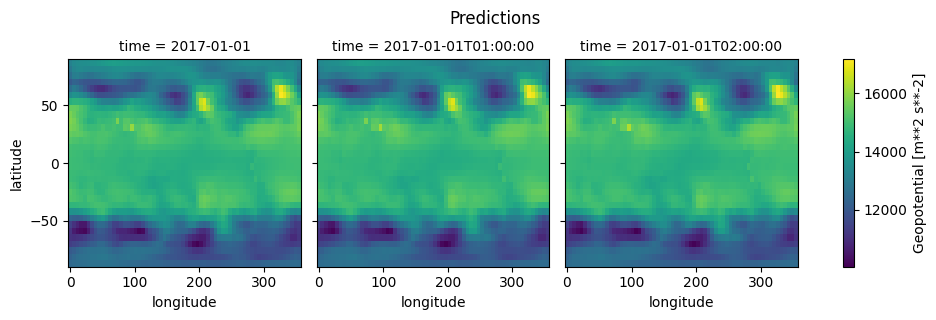

In [80]:
grid = y_preds.isel(time=slice(3))["z850"].plot(col="time")
grid.fig.suptitle("Predictions", y=1.05)

Text(0.5, 1.05, 'Ground truth')

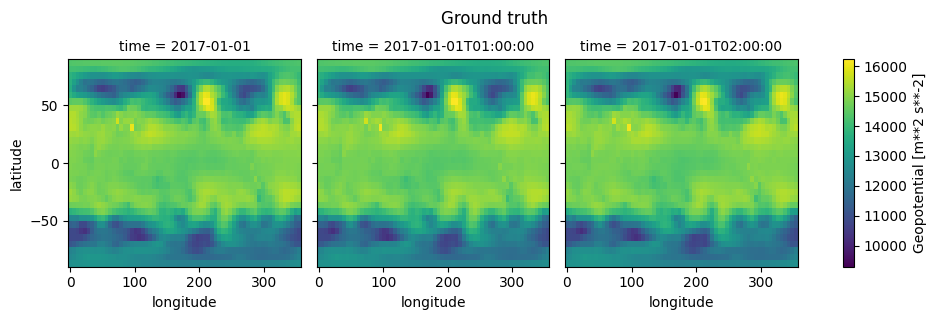

In [81]:
grid = y_true.isel(time=slice(3))["z850"].plot(col="time")
grid.fig.suptitle("Ground truth", y=1.05)

## Evaluation

In [82]:
mae_score = scores.continuous.mae(y_preds, y_true, preserve_dims=["latitude", "longitude"])

In [83]:
mae_score

<xarray.Dataset> Size: 435kB
Dimensions:    (latitude: 32, longitude: 64)
Coordinates:
  * latitude   (latitude) float64 256B -87.19 -81.56 -75.94 ... 81.56 87.19
  * longitude  (longitude) float64 512B 0.0 5.625 11.25 ... 343.1 348.8 354.4
Data variables: (12/53)
    2t         (latitude, longitude) float32 8kB 1.988 1.654 ... 1.76 2.281
    u50        (latitude, longitude) float32 8kB 1.101 1.116 ... 12.38 12.92
    u100       (latitude, longitude) float32 8kB 1.509 1.253 ... 4.478 5.219
    u150       (latitude, longitude) float32 8kB 1.81 1.791 ... 2.678 2.927
    u200       (latitude, longitude) float32 8kB 1.743 1.778 ... 1.537 1.82
    u250       (latitude, longitude) float32 8kB 2.147 2.099 ... 4.265 4.653
    ...         ...
    z500       (latitude, longitude) float32 8kB 459.3 236.3 ... 810.1 1.136e+03
    z600       (latitude, longitude) float32 8kB 353.0 246.7 ... 647.9 849.0
    z700       (latitude, longitude) float32 8kB 382.1 263.3 ... 524.7 725.8
    z850       (latitude, longitude) float32 8kB 415.4 332.3 ... 310.2 438.6
    z925       (latitude, longitude) float32 8kB 396.8 344.4 ... 245.8 339.1
    z1000      (latitude, longitude) float32 8kB 422.3 377.6 ... 234.7 291.6
Attributes:
    level-dtype:  int32

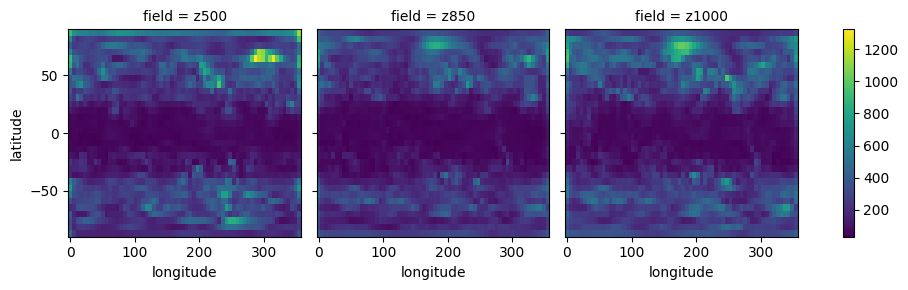

In [84]:
mae_score[["z500", "z850", "z1000"]].to_array(dim="field").plot(col="field")

## Additional Plotting

### Data Extraction

#### Slicing Method 

In [96]:
# Extract a slice of the 'z850' data ()
z850_preds = y_preds.isel(time=slice(1))['z850']

# Check the length of the 'time' dimension and squeeze if it is equal to one
if z850_preds.sizes['time'] == 1:
    z850_preds = z850_preds.squeeze(dim='time', drop=False)

#### Selecting individual time element

In [101]:
# Extract the predicted 't2m' variable for time index 0
t2m_preds = y_preds.isel(time=0)['2t']

In [ ]:
# Extract the true 't2m' variable for time index 0
t2m_true = y_true.isel(time=0)['2t']

### Define Plotting Mechanism

<Figure size 640x480 with 0 Axes>

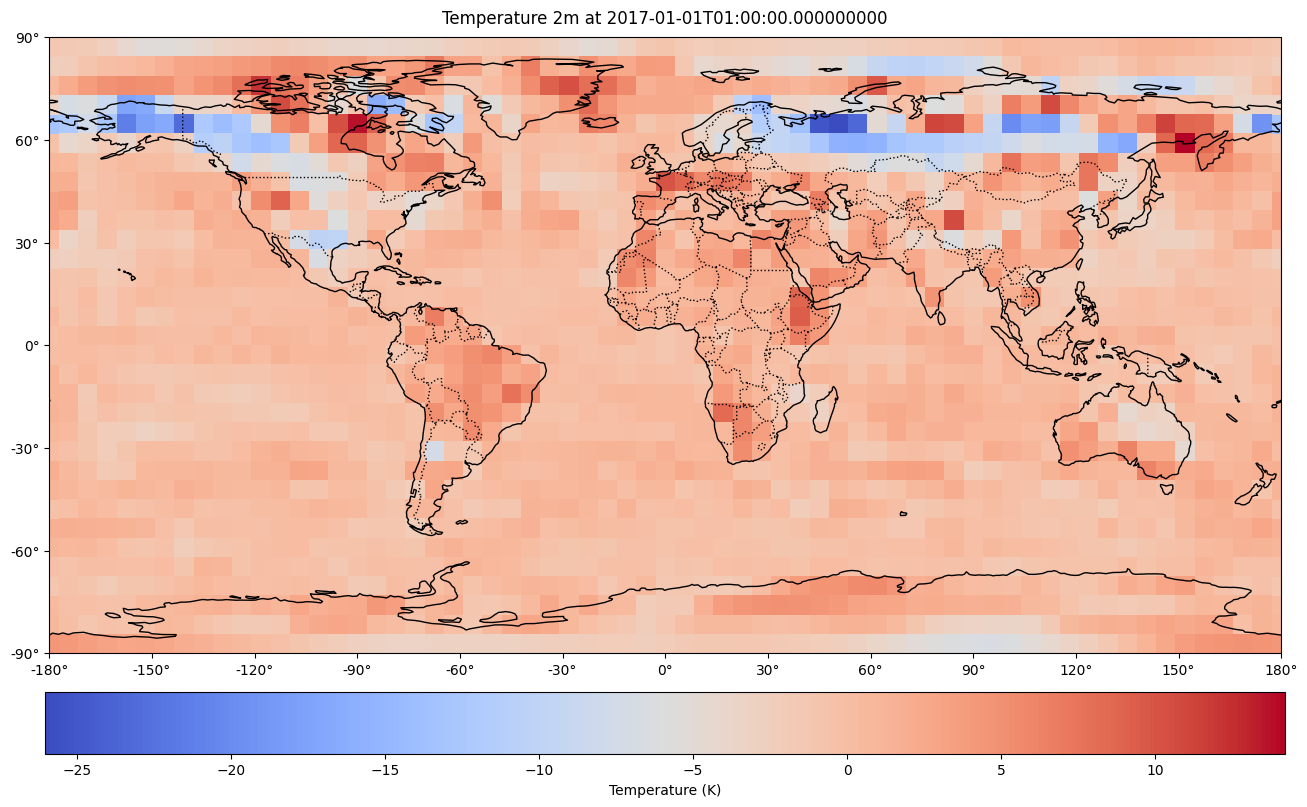

In [103]:
# Function to create a plot for a given time index
def plot_t2m(time_index):
    plt.clf()
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Extract the predicted 't2m' variable for the given time index
    t2m_preds = y_preds.isel(time=time_index)['2t']
    t2m_true = y_true.isel(time=time_index)['2t']

    # Calculate the difference between predicted and true 't2m' values
    t2m_diff = t2m_preds - t2m_true

    # Extract the time coordinate value
    time_value = t2m_preds.coords['time'].values

    # Extract latitude and longitude coordinates
    latitude = t2m_preds['latitude'].values
    longitude = t2m_preds['longitude'].values

    # Ensure longitude values are wrapped properly
    longitude = np.where(longitude > 180, longitude - 360, longitude)

    # Create the pcolormesh plot
    mesh = ax.pcolormesh(longitude, latitude, t2m_diff, cmap='coolwarm', transform=ccrs.PlateCarree())

    # Add coastlines and features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)

    # Add longitude and latitude labels
    ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

    # Add a colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Temperature (K)')

    # Set the title
    plt.title(f'Temperature 2m at {time_value}', pad=10)
    return fig

plot_t2m(1)


# Display the animation
plt.show()

## Plot of z850hPa predictions for the first test date
Cheack that the above plotting method works to produce the same plot as below.

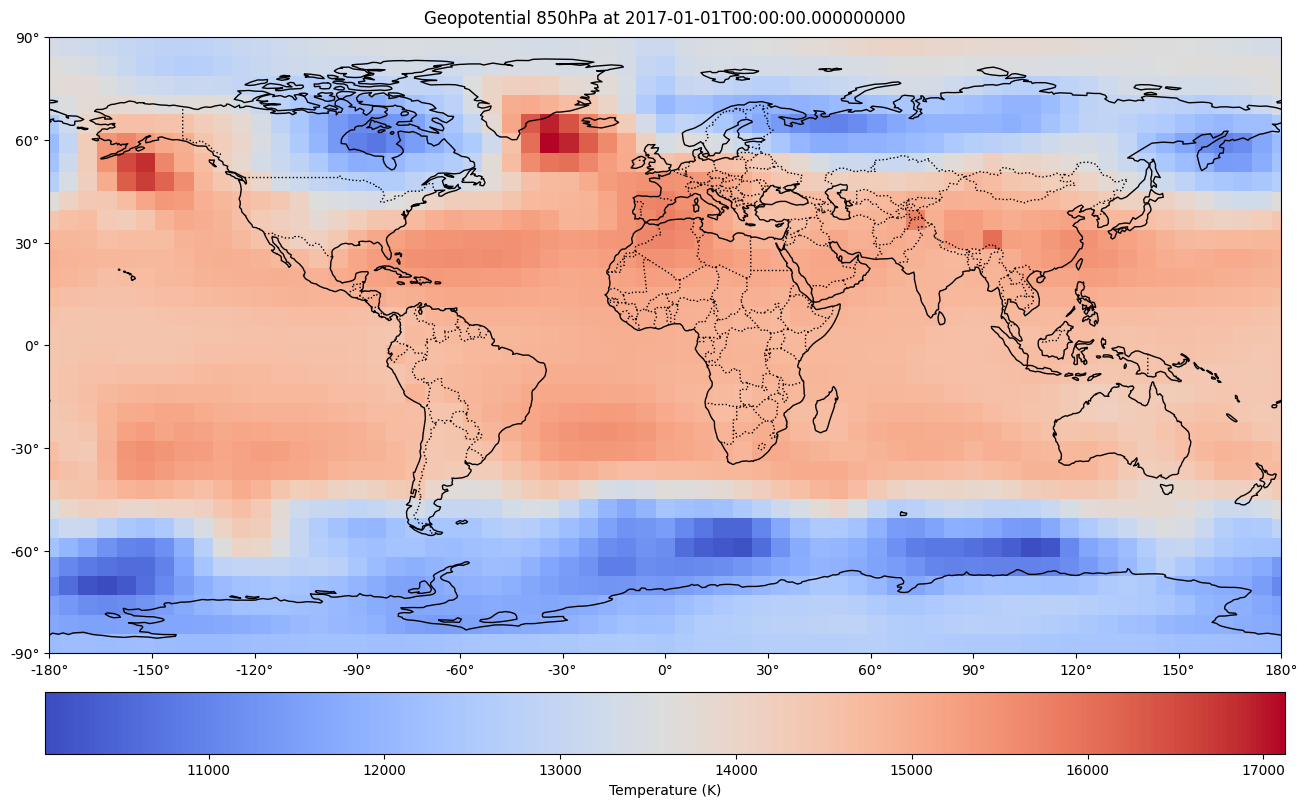

In [97]:
# Create a figure and an axis with a specific projection
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


# Extract the time coordinate value
time_value = z850_preds.coords['time'].values

# Extract latitude and longitude coordinates
latitude = z850_preds['latitude'].values
longitude = z850_preds['longitude'].values


# Ensure longitude values are wrapped properly
longitude = np.where(longitude > 180, longitude - 360, longitude)

# Create the pcolormesh plot
mesh = ax.pcolormesh(longitude, latitude, z850_preds, cmap='coolwarm', transform=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)

# Add longitude and latitude labels
ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

# Add a colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Temperature (K)')

# Set the title
plt.title(f'Geopotential 850hPa at {time_value}', pad=10)
plt.show()